In [1]:
%matplotlib notebook


In [2]:
# Import python modules
import numpy as np
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point, LineString, MultiPoint, Polygon
from sklearn.gaussian_process.kernels import Matern
from shapely.wkt import loads
from scipy.spatial.ckdtree import cKDTree
import matplotlib.pyplot as plt
import netCDF4
import h5py
import gc, sys, os
sys.path.append("../scripts")
import spatial_functions
import aem_utils
import netcdf_utils
import modelling_utils
import plotting_functions as plots
import warnings
import numpy.ma as ma
warnings.filterwarnings('ignore')

Import borehole and AEM data


In [4]:
# The actual inversoin data are stored on disk as netcdf files. NetCDF is an efficient format for storing 
# self-describing containerised data. 
# The implementation of netcdf for AEM line data was done by Alex Ip using his geophys_utils package.
# https://github.com/GeoscienceAustralia/geophys_utils/tree/master/geophys_utils

# Define path to the netcdf file
infile = r"C:\Users\PCUser\Desktop\AEM\LCI\SouthernStuart_WB_MGA53.nc"

# Create an instance
lci = aem_utils.AEM_inversion(name = 'Laterally Contrained Inversion (LCI)',
                              inversion_type = 'deterministic',
                              netcdf_dataset = netCDF4.Dataset(infile))

# As these inversions have already been gridded we will add these raster datasets to the instance using the
# load_lci_layer_grid() function. This function belongs to the AEM_inversion class.

# Directory in which the grids are located
infile = r"C:\Users\PCUser\Desktop\AEM\LCI\grids\SSC_LCI_layer_grids.p"

# Run function
#lci.load_lci_layer_grids_from_pickle(infile)


Let examine the results of this process. The inversion data is stored as an attribute of the inversion
class lci. It can be accessed by running the 'lci.data' command.


Create an instance of the garjmcmctdem inversion and probe the results using the same syntax as above.

Here we examine some of the attributes of the rj class

In [7]:
# Now we have the lines we can grid the lci conductivity data onto vertical grids (known as sections)
# this is the easiest way to visualise the AEM conuctivity in 2-dimensions

# Assign the lci variables to grid
grid_vars = ['conductivity', 'data_residual', 'depth_of_investigation']

# Define the resolution of the sections
xres, yres = 100., 5.

# We will use the lines from the rj

lines = np.unique(rj.data['line'][:].astype('int'))

#lines = [100201]

# Define the output directory if saving the grids as hdf plots

hdf5_dir = r"C:\temp\SSC_hdf5"

# if the directory doesn't exist, then create it
if not os.path.exists(hdf5_dir):
    os.mkdir(hdf5_dir)  

# Gridding takes a few minutes so I pre-gridded them for you. The lci.grid_sections()
# function below will do the gridding for you. Instead we will use the load_sectoin_from_file()
# function, which loads hdf5 files produced using the grid_sections() function


#lci.grid_sections(variables = grid_vars, lines = lines, xres = xres, yres = yres,
#                  return_interpolated = True, save_hdf5 = True, hdf5_dir = hdf5_dir)

lci.load_sections_from_file(hdf5_dir, grid_vars, lines = lines)

In [6]:
# Path to netcdf file
infile = r"C:\Users\PCUser\Desktop\AEM\rjmcmc\SSC_rjmcmc_pmaps.nc"

#import importlib
#importlib.reload(aem_utils)
#importlib.reload(netcdf_utils)
#importlib.reload(spatial_functions)

# Create instance
rj = aem_utils.AEM_inversion(name = 'GARJMCMCTDEM',
                              inversion_type = 'stochastic',
                             netcdf_dataset = netCDF4.Dataset(infile))

In [9]:
# Grid the rj sections

# Assign the lci variables to grid
grid_vars = ['conductivity_p10', 'conductivity_p50', 'conductivity_p90', 'interface_depth_histogram']

# Define the resolution of the sections
xres, yres = 100., 2.

# We will use the lines from the rj

lines = np.unique(rj.data['line'][:].astype('int'))

# Define the output directory if saving the grids as hdf plots

hdf5_dir = r"C:\temp\SSC_hdf5_rj"

# if the directory doesn't exist, then create it
if not os.path.exists(hdf5_dir):
    os.mkdir(hdf5_dir)  

rj.grid_sections(variables = grid_vars, lines = lines, xres = xres, yres = yres,
                  return_interpolated = True, save_hdf5 = True, hdf5_dir = hdf5_dir)


In [96]:
rj.section_data[lines[0]]['conductivity_p50']

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., 10., 10., 10.],
       [nan, nan, nan, ..., 10., 10., 10.],
       [nan, nan, nan, ..., 10., 10., 10.]], dtype=float32)

# 2. Visualise the data


Now let's quickly visualise the data. You can easily create your own plots if you are comfortable with the matplotlib python 
package. However, you may prefer to use some of the standard plots.

# 2.1 Map plot

Our first standard plot is an plot of gridded conductivity with the points inverted with GARJMCMCTDEM
plotted as points.

<IPython.core.display.Javascript object>


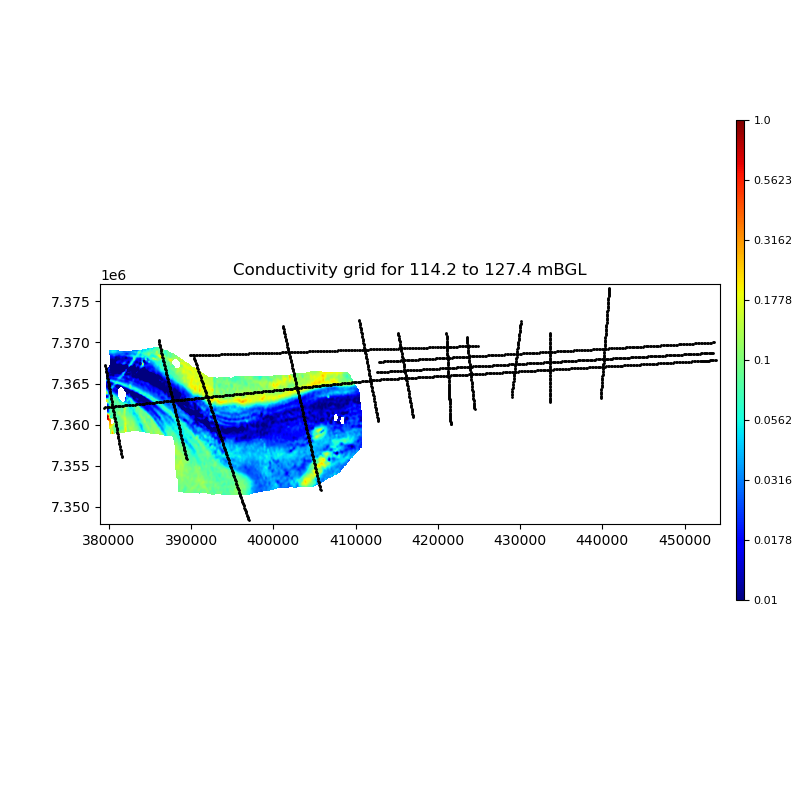

In [8]:
       
# In this notebook, standard plot key word arguments are passed to the plotting function as a python dictionary

# Here we explain each variable. Feel free to change and regenerate the plot
plot_args = {'Layer_number': 15, # Which AEM layer grid to plot from layer 1 (shallowest) to 30 (deepest)
             "figsize": (8,8), # The figure size in inches
             "vmin": 0.01, "vmax": 1., # The maximum and minimum conductivities in (S/m) for the grid colourstretch
             "point_size": 1, "point_colour": 'black', # Size and colour of the scatter plot points
             'colour_stretch': 'jet', # See matplotlib colourstretches
             'buffer': 500.} # The plot boundary will be buffered around the outer most scatter points.

plt.close('all')
# Do some plotting

fig, ax, cax = plots.AEM_baseplot(rj, lci, plot_args = plot_args)


plt.show()

# 2.2 Section plot

Our next standard plot is a vertical AEM section. The rather irregular length of sections means these are
commonly customised. As such we have left it to the user to define the size of the panels.

<IPython.core.display.Javascript object>


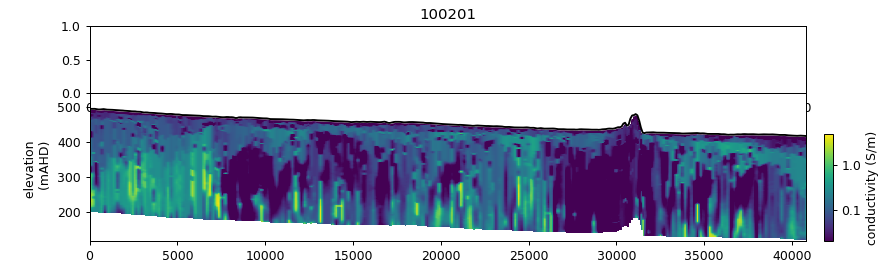

In [107]:
# Create a figures
plt.close('all')
fig = plt.figure(figsize = (10,3))

# Add two axes for the data misfit and the conductivity
# 
ax1 = fig.add_axes([0.1, 0.65, 0.8, 0.25])
ax2 = fig.add_axes([0.1, 0.1, 0.8, 0.55], sharex = ax1)

# Add a color
cbar_ax = fig.add_axes([0.92, 0.1, 0.01, 0.4])

panel_kwargs = [[],
                {'max_depth': 300.,
                      'shade_doi': False,
                      'colourbar': True,
                      'colourbar_label': 'Conductivity (S/m)',
                      'log_plot': True,
                      'vmin': 0.02,
                      'vmax': 5.,
                      'cmap': 'viridis',
                      'ylabel': 'elevation \n (mAHD)'}]

# define your line
line = 100201


cond_section = plots.plot_grid(ax2, rj.section_data[line], 'conductivity_p50',
                           panel_kwargs[1])

cb = fig.colorbar(cond_section, cax=cbar_ax, orientation='vertical')
    
cbar_ax.set_yticklabels([round(10 ** x, 4) for x in cb.get_ticks()])

cb.set_label('conductivity (S/m)', fontsize=10)

ax1.set_title(str(line))

plt.show()

In [ ]:
# Create a figures
plt.close('all')
fig = plt.figure(figsize = (10,3))

# Add two axes for the data misfit and the conductivity
# 
ax1 = fig.add_axes([0.1, 0.65, 0.8, 0.25])
ax2 = fig.add_axes([0.1, 0.1, 0.8, 0.55], sharex = ax1)

# Add a color
cbar_ax = fig.add_axes([0.92, 0.1, 0.01, 0.4])

panel_kwargs = [{'title': '',
                      'color': 'black',
                      'ylabel': 'data \n residual',
                      'legend': False,
                      },
                     {'max_depth': 200.,
                      'shade_doi': False,
                      'colourbar': True,
                      'colourbar_label': 'Conductivity (S/m)',
                      'log_plot': True,
                      'vmin': 0.02,
                      'vmax': 5.,
                      'cmap': 'viridis',
                      'ylabel': 'elevation \n (mAHD)'}]

# define your line
line = 100201

res = plots.plot_single_line(ax1, rj.section_data[line],
                                   'data_residual', panel_kwargs[0])

cond_section = plots.plot_grid(ax2, lci.section_data[line], 'conductivity',
                           panel_kwargs[1])

cb = fig.colorbar(cond_section, cax=cbar_ax, orientation='vertical')
    
cbar_ax.set_yticklabels([round(10 ** x, 4) for x in cb.get_ticks()])

cb.set_label('conductivity (S/m)', fontsize=10)

ax1.set_title(str(line))


In [119]:
lines

masked_array(data=[100101, 100201, 100301, 100401, 100501, 100601, 100701,
                   100801, 100901, 101001, 101101, 101201, 101301, 101401,
                   101501],
             mask=False,
       fill_value=999999)

<IPython.core.display.Javascript object>


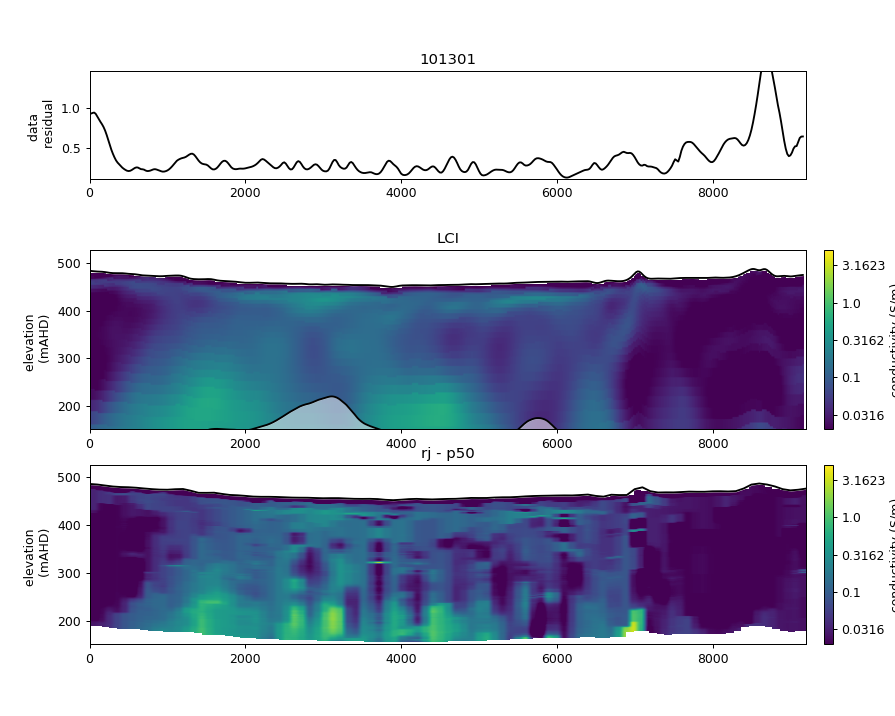

In [25]:
# Create a figures
plt.close('all')
fig = plt.figure(figsize = (10,8))

# Add two axes for the data misfit and the conductivity
# 
ax1 = fig.add_axes([0.1, 0.75, 0.8, 0.15])
ax2 = fig.add_axes([0.1, 0.4, 0.8, 0.25], sharex = ax1)
ax3 = fig.add_axes([0.1, 0.1, 0.8, 0.25], sharex = ax1)

# Add a color
cbar_ax2 = fig.add_axes([0.92, 0.4, 0.01, 0.25])
cbar_ax3 = fig.add_axes([0.92, 0.1, 0.01, 0.25])

panel_kwargs = [{'title': '',
                      'color': 'black',
                      'ylabel': 'data \n residual',
                      'legend': False,
                      },
                     {'max_depth': 300.,
                      'shade_doi': True,
                      'colourbar': True,
                      'colourbar_label': 'Conductivity (S/m)',
                      'log_plot': True,
                      'vmin': 0.02,
                      'vmax': 5.,
                      'cmap': 'viridis',
                      'ylabel': 'elevation \n (mAHD)'},
                     {'max_depth': 300.,
                      'shade_doi': False,
                      'colourbar': False,
                      'colourbar_label': 'Conductivity (S/m)',
                      'log_plot': True,
                      'vmin': 0.02,
                      'vmax': 5.,
                      'cmap': 'viridis',
                      'ylabel': 'elevation \n (mAHD)'}]

# define your line
line = lines[12]

res = plots.plot_single_line(ax1, lci.section_data[line],
                                   'data_residual', panel_kwargs[0])

lci_section = plots.plot_grid(ax2, lci.section_data[line], 'conductivity',
                           panel_kwargs[1])

rj_section = plots.plot_grid(ax3, rj.section_data[line], 'conductivity_p50',
                           panel_kwargs[2])

cb2 = fig.colorbar(lci_section, cax=cbar_ax2, orientation='vertical')
    
cbar_ax2.set_yticklabels([round(10 ** x, 4) for x in cb2.get_ticks()])

cb2.set_label('conductivity (S/m)', fontsize=10)

cb3 = fig.colorbar(rj_section, cax=cbar_ax3, orientation='vertical')
    
cbar_ax3.set_yticklabels([round(10 ** x, 4) for x in cb3.get_ticks()])

cb3.set_label('conductivity (S/m)', fontsize=10)

ax1.set_title(str(line))
ax2.set_title('LCI')
ax3.set_title('rj - p50')

plt.savefig(r"C:\Temp\AS_composite_sections\\" + str(line) + '.png', dpi = 200)
plt.show()

# 3 Setup your model

Now we want to create a model boundary object for our interpreted surface. As with AEM inversions our interpreted surface will be an instance of a python class. However, this class is called modelled boundary and has different data and funcionality.

For this interpretation job we are using the schema defined for the AusAEM interpretation.

In [11]:
# Create an modelled boundary instance

headings = ['fiducial', 'inversion_name"' 'X', 'Y', 'ELEVATION', "DEM", "DEPTH", "BoundaryNm", "BoundConf",
            "BasisOfInt", "OvrConf", "InterpRef", "Comment", "SURVEY_LINE"]

interp_file = r"C:\temp\Mereenie-Pertnjara_interface_interpreted_points.csv"

MP_surface = modelling_utils.modelled_boundary(name = 'Mereenie-Pertnjara interface',
                                            outfile_path = interp_file,
                                            interpreted_point_headings = headings)
# Set some custom attributes for the interface. Eventually this 
# will be built in
MP_surface.Type = "PAL-W" #within palaeozoic
MP_surface.OvrStrtUnt = "Pertnjara Formation"
MP_surface.OvrStrtCod = 15098
MP_surface.UndStrtUnt = "Mereenie Sandstone"
MP_surface.UndStrtUnt = 11667
MP_surface.Operator = "Neil Symington"

In [12]:
# # Create an modelled boundary instance

headings = ['fiducial', 'inversion_name"' 'X', 'Y', 'ELEVATION', "DEM", "DEPTH", "TYPE", "BoundaryNm", "BoundConf",
            "BasisOfInt", "OvrConf", "InterpRef", "Comment", "SURVEY_LINE"]


interp_file = r"C:\temp\Pertnjara-Cenozoic_interface_interpreted_points.csv"

PC_surface = modelling_utils.modelled_boundary(name = 'Pertnjara-Cenozoic interface',
                                            outfile_path = interp_file,
                                            interpreted_point_headings = headings)
# Set some custom attributes for the interface. Eventually this 
# will be built in
PC_surface.OvrStrtUnt = "Cenozoic Regolith" # Todo check if this is right
PC_surface.OvrStrtCod = 76542
PC_surface.UndStrtUnt = "Pertnjara Formation"
PC_surface.UndStrtUnt = 15098
PC_surface.Operator = "Neil Symington"

# 4 Interpreting



# 4.1 Sampling




In [13]:
# For simplicity we will do line at a time
line = 101301

line_mask = netcdf_utils.get_lookup_mask(lines,
                                         rj.data)

SyntaxError: invalid syntax (<ipython-input-13-5ed7be45f985>, line 2)

In [36]:
# Next we define 
pmap_kwargs = {# Panel 1 is the 2d histogram of conductivity and depth.
               # Counts are converted to probabilities
               'panel_1': {'min_depth': 0,
                           'max_depth': 300.,
                           'cmap': 'rainbow'},
               # Panel 2 is the change point histogram panel. This shows
               # where we are most likely to have layer boundaries.
              'panel_2': {'auto_xlim': True,
                          'pmin': 0.001,
                          'pmax': 1.},
               # panel 3 is the interpolated surface grid described above.
              'panel_3': {'vmin': -300,
                          'vmax': 0.},
               # panel 4 shows the misfit for our MCMC chains. This plot shows
               # if our model has converged
              'panel_4': {'misfit_min': 0.01,
                          'misfit_max': 1e4},
               # panel 5 shows the lci misft for a section.
              'panel_5': {'title': '',
                      'color': 'black',
                      'ylabel': 'data \n residual',
                      'legend': False,
                         'buffer': 5000.},
               # panel 6 shows the lci conducivity Section
              'panel_6': {'title': 'LCI conductivity',
                      'max_depth': 200.,
                      'vmin': 0.001,
                      'vmax': 1,
                      'cmap': 'jet',
                      'ylabel': 'elevation \n (mAHD)',
                       'buffer': 5000.,
                       'shade_doi': False},
               # panel 7 shows the gridded AEM conductivity.
              'panel_7': {'Layer_number': 4,
                          "vmin": 0.001, "vmax": 1.,
                          'cmap': 'jet',
                          'buffer': 20000.}}

In [62]:
import importlib
importlib.reload(plots)
importlib.reload(netcdf_utils)

<module 'netcdf_utils' from '../scripts\\netcdf_utils.py'>

rj point index is  1778
Fidicial is  692537.5


<IPython.core.display.Javascript object>


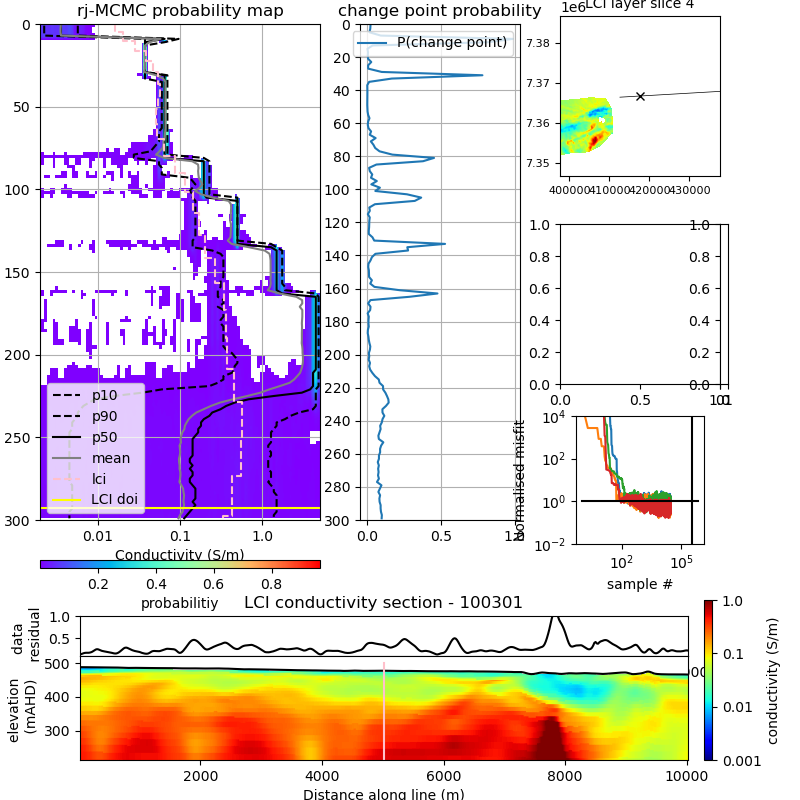

In [63]:
# Run the pmap interpretation again

plt.close('all')

# define our point from the points array using the index i
point_index = 1778

# Extract the data from the netcdf data
D = netcdf_utils.extract_rj_sounding(rj, lci, point_index)

# print the poit index and fiducial for our reference
print("rj point index is ", point_index)
print("Fidicial is ", D['fiducial'])

# create the figure
fig, ax_array = plots.pmap_plot(D, pmap_kwargs, surface, lci)

# show the plot
plt.show()

#cid=  fig.canvas.mpl_connect('button_press_event', pmap_click)

#i+=1

The pmap click function below is what allows us to interact with the plots. The click2estimate function takes a click from the plot and returns and interpretation. The function searches all points within the snap window (which is defined as 16 here) and finds the local maximum porbability of an interface. This is in effect snapping to the most likely interface within the serach region. If you are highly confident in your picks you can reduce the snap window.


It also returns the thickness of the probability intervals that is >0.5 times the local maximum probability. In many areas, especially at depth this method returns errors that are unrealistically high. Thus the user can define a standard deviation ceilling (stdev_ceiling) or a maximum possible standard deviation.

In [195]:
# The results are saved to the same file we imported earlier
outfile = "../../workshop_data/interpretation/rj_interp_Cretaceous.csv"

# Interpretations ar saved to this list
interpretations = []

# Define the interative parameters
snap_window = 16
stdev_ceiling = 20.

# pmaps function
def pmap_click(event):
    if event.xdata != None and event.ydata != None:
        #We will use fiducial as a key

        depth, stdev = modelling_utils.click2estimate(D, event.ydata,
                                                       snap_window = snap_window,
                                                       stdev_ceiling = stdev_ceiling)
        # append to the surface object interpreted points
        interp = {'fiducial': D['fiducial'],
                  'easting': D['easting'],
                  'northing': D['northing'],
                  'layer_depth': np.round(depth,0),
                  'layer_elevation': np.round(D['elevation'] - event.ydata,2),
                  'interpretation_uncertainty': np.round(stdev,0)}
        
        #interpretations.append(interp)                        
        df = pd.DataFrame(interp, index = [0]).set_index('fiducial')

        try:
            surface.interpreted_points = surface.interpreted_points.append(df, verify_integrity = True)
        # Value error is if the point has already been interpreted
        except ValueError:
            surface.interpreted_points.loc[df.index, df.columns] = df.values[0]

        # Save the interpretation
        surface.interpreted_points.to_csv(outfile)


masked_array(data=[ 1,  4,  0,  2,  3,  3,  5,  6,  7,  8, 10, 11,  9],
             mask=False,
       fill_value=999999)

(13,)